# Análise de Séries Temporais - Imóveis Retomados 

## Importando as bibliotecas usadas no projeto

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro, anderson, boxcox

## Passo 1 - Pré-processamento dos dados 

#### Leitura da base de dados utilizada neste projeto

In [2]:
df = pd.read_excel('base_temporais.xlsx')

#### Visualizando as primeiras linhas de dados

In [3]:
df.head()

,data,quantidade_dossies
0,2021-01-01,7
1,2021-02-01,5
2,2021-03-01,1
3,2021-04-01,5
4,2021-05-01,6


#### Obtendo informações sobre as colunas presente no dataset, precisamos que a coluna 'data' seja do tipo datetime

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data                43 non-null     datetime64[ns]
 1   quantidade_dossies  43 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 820.0 bytes


#### Tratando a coluna data e tranformando em datetime

In [5]:
df = df[pd.to_datetime(df['data'], errors='coerce').notna()]
df['data'] = pd.to_datetime(df['data'])

#### Para algoritmos de séries temporais usamos a data como índice do dataset

In [6]:
df.set_index('data', inplace=True)

#### Printando as primas linhas e obtendo informações sobre o dataset

In [7]:
print(df.head())
df.describe()

            quantidade_dossies
data                          
2021-01-01                   7
2021-02-01                   5
2021-03-01                   1
2021-04-01                   5
2021-05-01                   6


,quantidade_dossies
count,43.000000
mean,15.465116
std,8.677691
min,1.000000
25%,7.000000
50%,15.000000
75%,22.000000
max,35.000000


#### Plotando a série para visualização geral

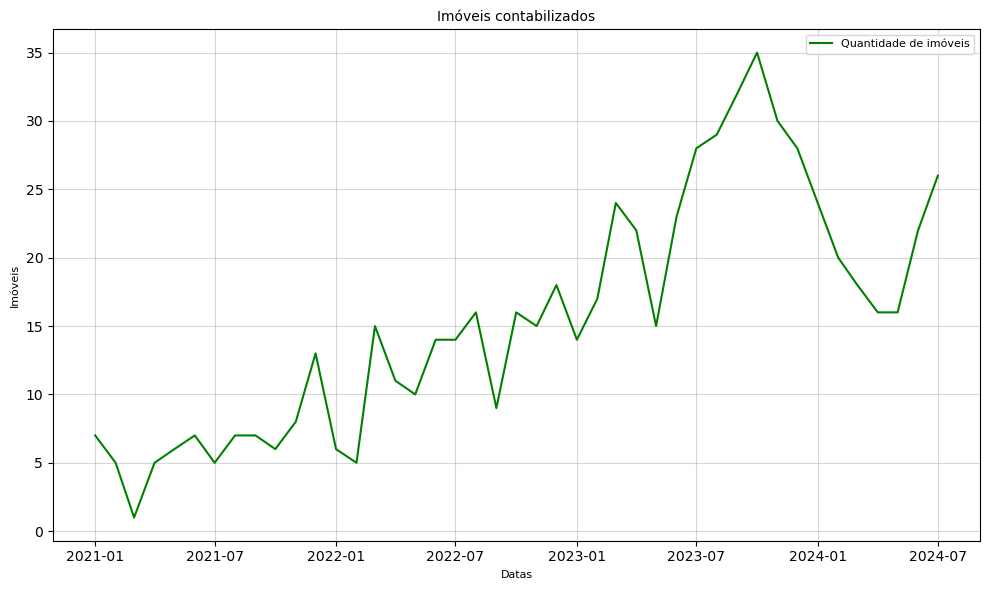

In [8]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['quantidade_dossies'], label='Quantidade de imóveis', color='g')

plt.title('Imóveis contabilizados', fontsize=10)
plt.xlabel('Datas', fontsize=8)
plt.ylabel('Imóveis', fontsize=8)

plt.legend(fontsize=8)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

#### Plotando a série com sua Média, Mediana e Tendência 

Média: 15.465116279069768
Mediana: 15.0


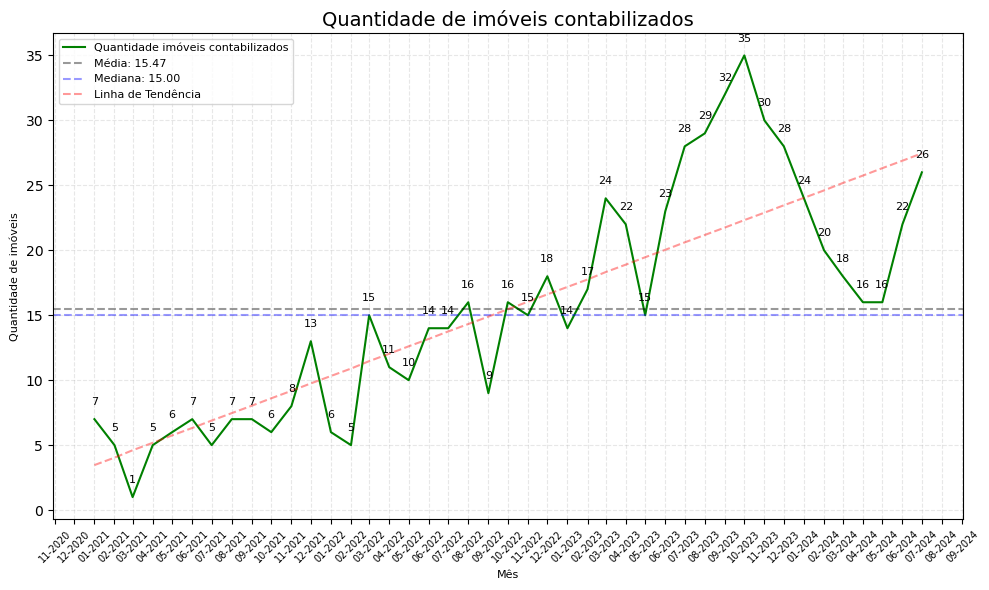

In [9]:
media_retomadas = np.mean(df['quantidade_dossies'])
print(f'Média: {media_retomadas}')

mediana_retomadas = np.median(df['quantidade_dossies'])
print(f'Mediana: {mediana_retomadas}')

x_vals = np.arange(len(df.index))

# Ajustar uma linha reta (polinômio de grau 1) aos dados
coef = np.polyfit(x_vals, df['quantidade_dossies'], 1)
poly1d_fn = np.poly1d(coef)

# Plotando o gráfico
plt.figure(figsize=(10,6))
plt.plot(df.index, df['quantidade_dossies'], color='g', label='Quantidade imóveis contabilizados')

plt.title('Quantidade de imóveis contabilizados', fontsize=14)
plt.xlabel('Mês', fontsize=8)
plt.ylabel('Quantidade de imóveis', fontsize=8)

# Adicionar a linha de média
plt.axhline(y=media_retomadas, color='k', linestyle='--', label=f'Média: {media_retomadas:.2f}', alpha=0.4)

# Adicionar a linha de média
plt.axhline(y=mediana_retomadas, color='b', linestyle='--', label=f'Mediana: {mediana_retomadas:.2f}', alpha=0.4)

# Adicionar a linha de tendência
plt.plot(df.index, poly1d_fn(x_vals), color='r', linestyle='--', label='Linha de Tendência', alpha =0.4)

# Adicionar rótulos de dados
for x, y in zip(df.index, df['quantidade_dossies']):
    plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(fontsize=7)
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

## Passo 2 - Decomposição do DataFrame para análise de sazonalidades, tendências e resíduos

### Componentes das Séries Temporais

As séries temporais são compostas por quatro componentes principais:

1. **Tendência (T):** 
   - É o comportamento dos dados ao longo do tempo, por um prazo longo de tempo.

2. **Variações cíclicas (C):**
   - Flutuações nos valores das variáveis com duração superior a um ano e que se repetem com alguma periodicidade.
   - Podem ser resultado da variação da economia mundial, fenômenos climáticos, entre outros.

3. **Variações sazonais ou sazonalidade (S):**
   - Flutuações nos valores das variáveis com duração menor de um ano.
   - Normalmente ocorrem devido às estações do ano, feriados, festas populares ou exigências legais.

4. **Variações irregulares (I):**
   - São as flutuações inexplicáveis, resultado de fatos aleatórios.
órios.

### Componente TENDÊNCIA (T)

Vamos isolar a componente Tendência (T) para entender melhor o comportamento da série ao longo do tempo. A tendência reflete a direção geral dos dados (aumento, diminuição ou constância) em um período mais longo. Para analisar a componente de tendência, vamos utilizar o método de médias móveis, que suaviza as flutuações de curto prazo e destaca a direção geral da série temporal. Para está análise estamos utilizando o período de 3 meses para as médias móveis.

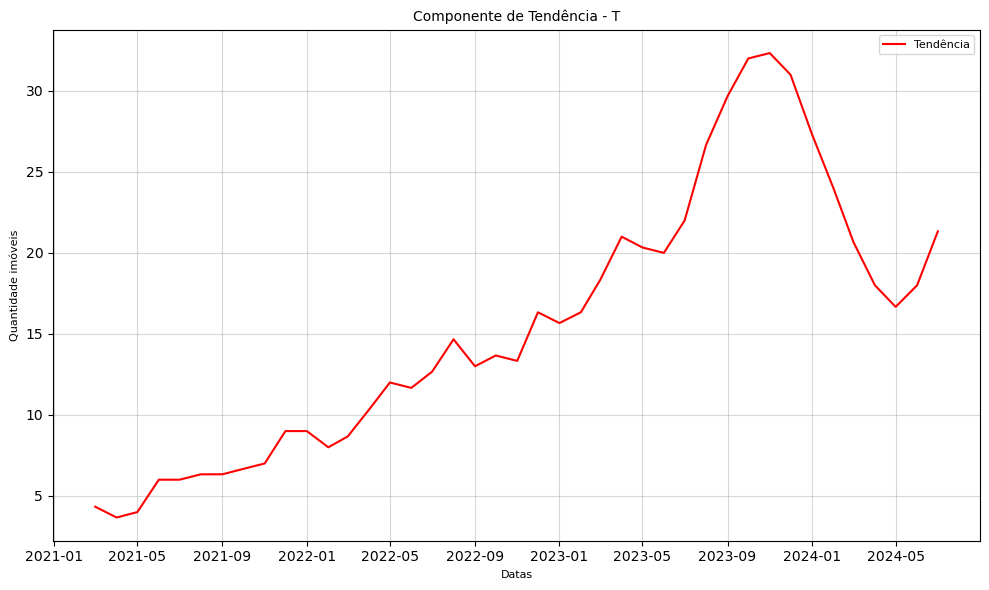

In [10]:
tendencia = df.rolling(3).mean()

plt.figure(figsize=(10,6))
plt.plot(tendencia, label='Tendência', color='r')

plt.title('Componente de Tendência - T', fontsize=10)
plt.xlabel('Datas', fontsize=8)
plt.ylabel('Quantidade imóveis', fontsize=8)

plt.grid(True, alpha=0.5)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

### Componeste SAZONALIDADE (S)

Vamos isolar agora a componente Sazonalidade (S) para entender melhor o comportamento da série em determinados intervalos de tempo. Séries temporais com sazonalidade bem definida se encaixam bem no modelo de suavização exponencial de Holt-Winters. Para isso, vamos utilizar o método seasonal_decompose da biblioteca statsmodels.

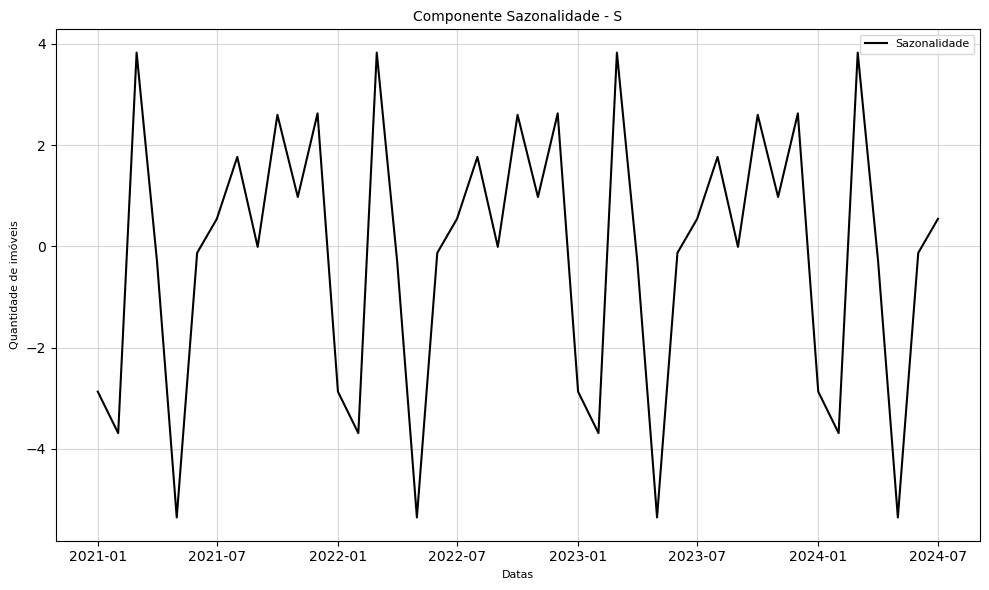

In [11]:
# A coluna do índice deve ser de data para facilitar a decomposição sazonal
df.index = pd.to_datetime(df.index)

# Decompondo a série temporal (assumindo periodicidade mensal, ou seja, 12)
decomposition = seasonal_decompose(df['quantidade_dossies'], model='additive', period=12)

# Extraindo a componente sazonal
sazonalidade = decomposition.seasonal

# Plotando a componente sazonal
plt.figure(figsize=(10, 6))
plt.plot(sazonalidade, label='Sazonalidade', color='k')

plt.title('Componente Sazonalidade - S', fontsize=10)
plt.xlabel('Datas', fontsize=8)
plt.ylabel('Quantidade de imóveis', fontsize=8)

plt.grid(True, alpha=0.5)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


Para facilitar na visualização da sazonalidade vamos criar um gráfico com a sazonalidade agrupada pelos meses do ano.

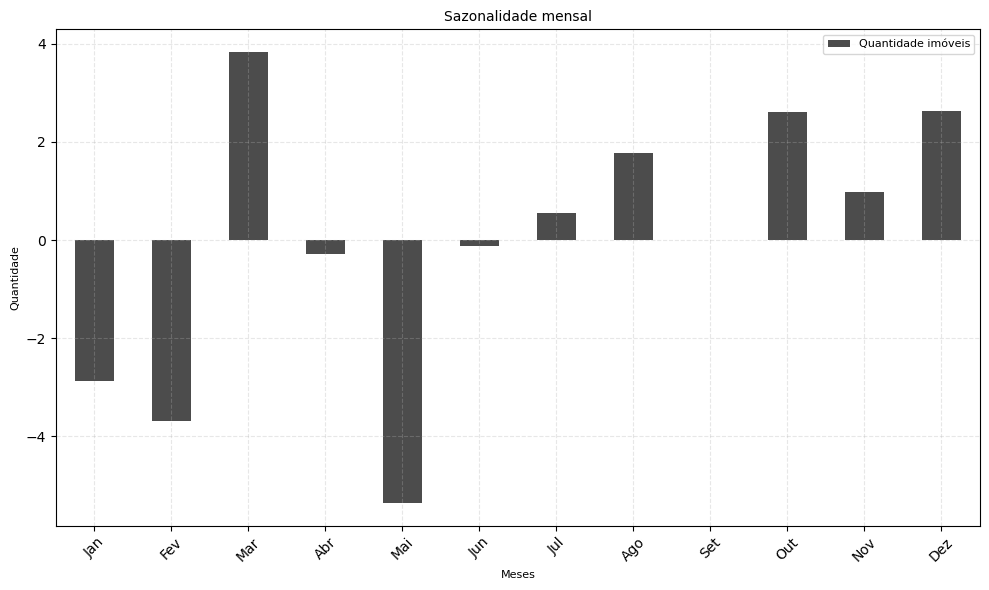

In [12]:
# Análise de sazonalidade agrupada por meses
sazonalidade_agrupada = sazonalidade.groupby(df.index.month).mean()

plt.figure(figsize=(10,6))
ax = sazonalidade_agrupada.plot(kind='bar', color='k', alpha=0.7)

plt.title('Sazonalidade mensal', fontsize=10)
plt.xlabel('Meses', fontsize=8)
plt.ylabel('Quantidade', fontsize=8)

plt.xticks(ticks=range(12), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)

plt.grid(True, alpha=0.3, linestyle='--')

# Adicionando a legenda manualmente
ax.legend(['Quantidade imóveis'], fontsize=8)

plt.tight_layout()
plt.show()


### Componente RESÍDUO (R)

Vamos isolar agora a componente Resíduo (R) para entender melhor as flutuações imprevisíveis da série temporal. Os resíduos representam as variações inexplicáveis que permanecem após a remoção das componentes de tendência e sazonalidade. Para analisar a componente de resíduo, vamos utilizar o método seasonal_decompose da biblioteca statsmodels. Isso nos ajudará a identificar e entender os padrões de variação aleatória na série temporal.

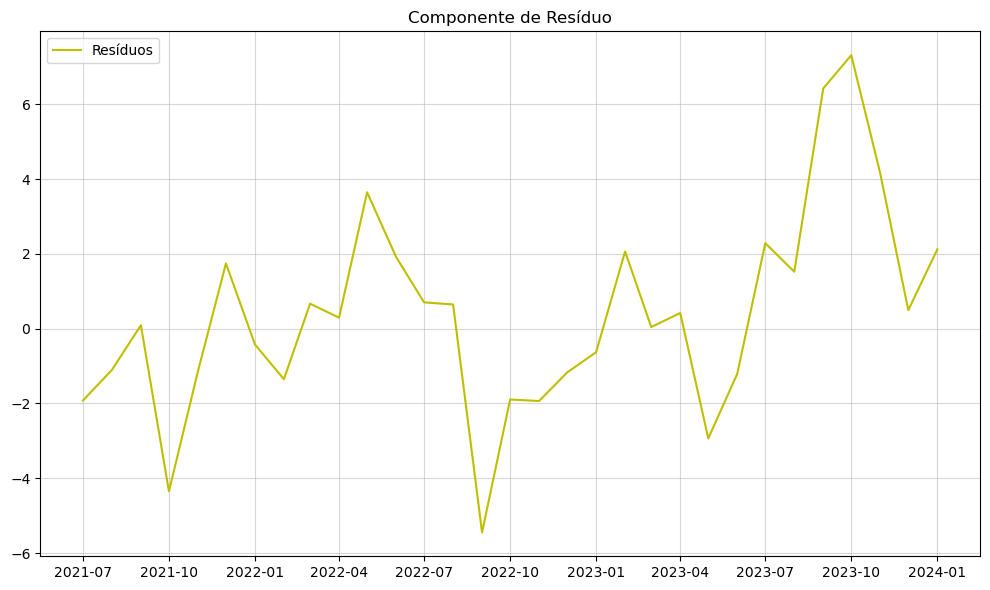

In [13]:
# Decomposição da série temporal (tendência, sazonalidade, resíduos)
decomposition = seasonal_decompose(df['quantidade_dossies'], model='additive', period=12) 

# Plotar a decomposição
plt.figure(figsize=(10, 6))

plt.subplot()
plt.plot(df.index, decomposition.resid, label='Resíduos', color='y')
plt.legend(loc='upper left')

plt.title('Componente de Resíduo')

plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

## Passo 3 - Criação do modelo de previsão com algorítmo de Suavização Exponecial

#### O algoritmo de Holt-Winters

O modelo de suavização exponencial de Holt-Winters, também conhecido como método de Holt-Winters, é uma extensão da suavização exponencial simples que acomoda a sazonalidade e a tendência em séries temporais. É particularmente útil quando os dados apresentam padrões sazonais (repetitivos) e tendências que mudam ao longo do tempo. O modelo de Holt-Winters pode ser aplicado de duas maneiras principais: aditiva e multiplicativa, dependendo da natureza da sazonalidade.
Como nossa sazonalidade se demonstrou aditiva e temos variações da tendência ao longo do tempo, vamos utilizar o método de Holt-Winters aditivo.

#### Treinando o modelo

Para criar o modelo, iremos dividir os dados disponíveis em conjuntos de treino e teste, usando uma proporção de 60/40, respectivamente. Após testar os dados, utilizaremos métricas de avaliação, como o Erro Absoluto Médio (MAE) e o Erro Quadrático Médio (MSE), para comparar as previsões do modelo com os dados reais. Isso nos permitirá medir a precisão e o ajuste do nosso modelo de previsão em relação à realidade.

In [14]:
warnings.filterwarnings("ignore")

# Divisão dos dados em treino e teste
train_size = int(len(df) * 0.6)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Ajuste do modelo de suavização exponencial aos dados de treino
model = ExponentialSmoothing(train['quantidade_dossies'], trend='additive', seasonal='additive', seasonal_periods=12, damped=True)
result = model.fit(optimized=True)

# Previsão para os dados de teste
previsao_teste = result.forecast(steps=len(test))

# Calcular métricas de avaliação
mae = mean_absolute_error(test['quantidade_dossies'], previsao_teste)
mse = mean_squared_error(test['quantidade_dossies'], previsao_teste)
rmse = np.sqrt(mse)

print(f'Erro Absoluto Médio MAE: {mae}')
print(f'Erro Quadrático Médio MSE: {mse}')

Erro Absoluto Médio MAE: 6.271335970016733
Erro Quadrático Médio MSE: 57.60746925590029


#### Plotando as previsões de teste

Após testar o modelo e medir as previsões, iremos plotar os dados de teste previstos pelo modelo e os dados reais para visualizar a performance do nosso modelo. Isso nos permitirá identificar visualmente como o modelo está se comportando e quão bem ele está capturando os padrões presentes nos dados reais.

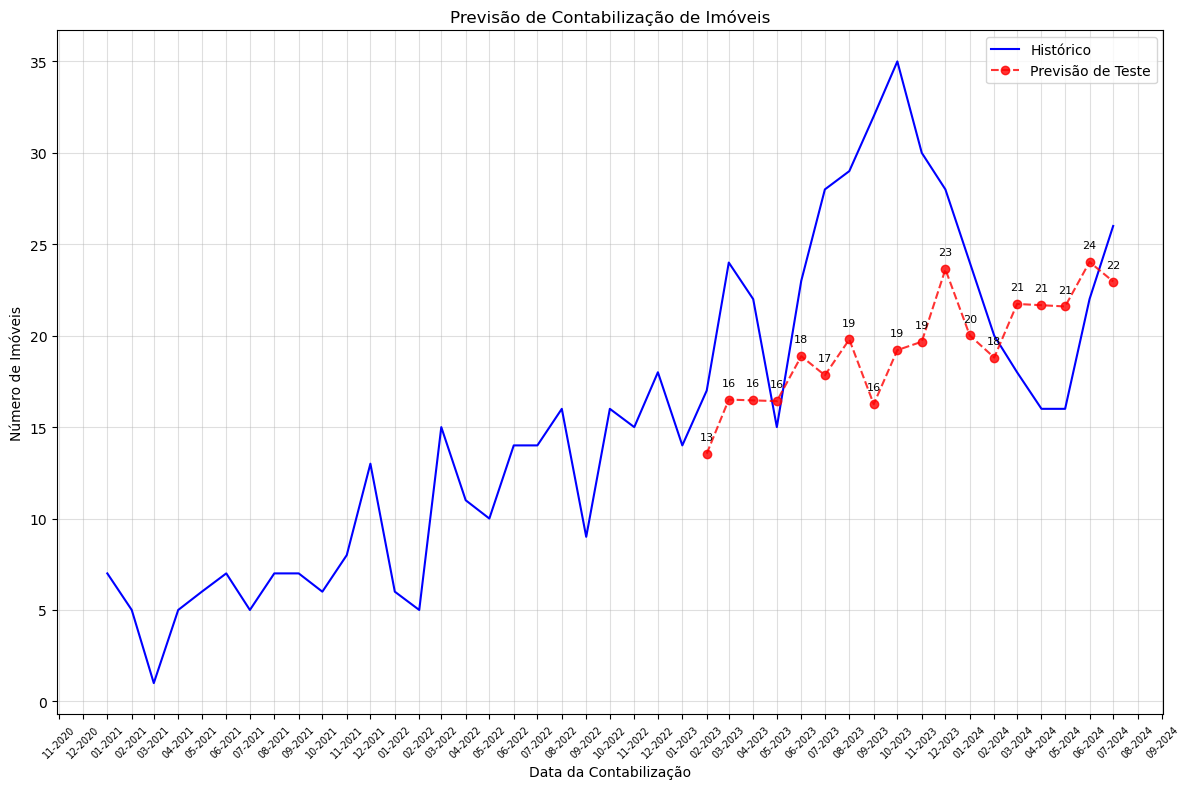

In [15]:
# Visualização das previsões
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['quantidade_dossies'], linestyle='-', color='b', label='Histórico')
plt.plot(test.index, previsao_teste, marker='o', linestyle='--', color='r', label='Previsão de Teste', alpha=0.8)

# Adicionar rótulos de dados nos pontos da previsão de teste
for i in range(len(previsao_teste)):
    plt.annotate(f'{int(previsao_teste[i])}', 
                 (previsao_teste.index[i], previsao_teste[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 fontsize=8)

plt.xlabel('Data da Contabilização')
plt.ylabel('Número de Imóveis')
plt.title('Previsão de Contabilização de Imóveis')

# Ajuste do eixo x para mostrar meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(fontsize=7)

plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

### Verificando o ajuste do modelo através dos resíduos

Após testar o modelo e medir sua precisão, precisamos extrair a componente de resíduo e analisar seu comportamento. É importante que os resíduos sejam distribuídos normalmente e que sejam brancos, ou seja, totalmente aleatórios. Isso garante que nosso modelo esteja bem ajustado aos dados reais, sem padrões não capturados pelo modelo. Para isso, utilizaremos o método seasonal_decompose para extrair a componente de sazonalidade e aplicaremos três testes de normalidade nos resíduos.

#### Testes de Normalidade

#### 1. Teste de Shapiro-Wilk
- **Estatística W:** Varia de 0 a 1, onde valores próximos a 1 indicam que a distribuição é próxima da normal.
- **p-valor:** Um p-valor pequeno (geralmente menor que 0.05) indica que a hipótese nula de normalidade deve ser rejeitada. Ou seja, os dados não seguem uma distribuição normal.

##### Interpretação:
- Se W é próximo de 1 e o p-valor é maior que 0.05, você não rejeita a hipótese nula de que os resíduos são normalmente distribuídos.
- Se o p-valor é menor que 0.05, rejeita-se a hipótese nula, sugerindo que os resíduos não são normalmente distribuídos.

#### 2. Teste de Anderson-Darling
- **Estatística A:** Não tem uma faixa fixa de valores, mas é comparada com valores críticos para diferentes níveis de significância.
- **Valores críticos:** Para cada nível de significância (e.g., 1%, 5%, 10%), há um valor crítico.

##### Interpretação:
- Se a estatística A é menor que o valor crítico para um dado nível de significância, você não rejeita a hipótese nula de que os resíduos são normalmente distribuídos.
- Se a estatística A é maior que o valor crítico, rejeita-se a hipótese nula, indicando que os resíduos não são normalmente distribuídos.

#### 3. Teste de D'Agostino's K-squared
- **Estatística K-squared:** Mede a combinação da assimetria e curtose da distribuição dos resíduos.
- **p-valor:** Um p-valor pequeno (geralmente menor que 0.05) indica que a hipótese nula de normalidade deve ser rejeitada.

##### Interpretação:
- Se o p-valor é maior que 0.05, você não rejeita a hipótese nula de que os resíduos são normalmente distribuídos.
- Se o p-valor é menor que 0.05, rejeita-se a hipótese nula, sugerindo que os resíduos não são normalmente distribuídos.


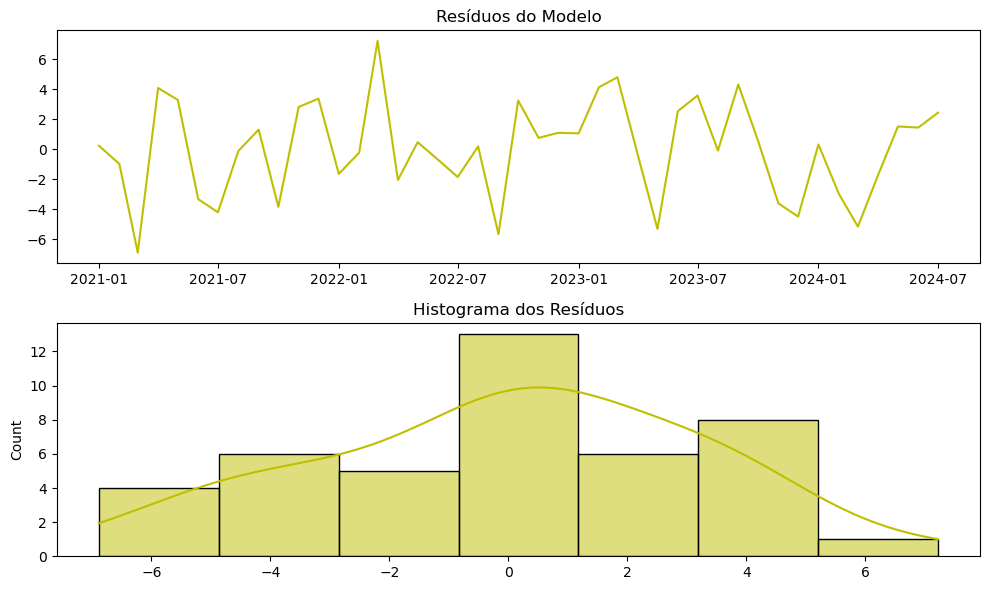

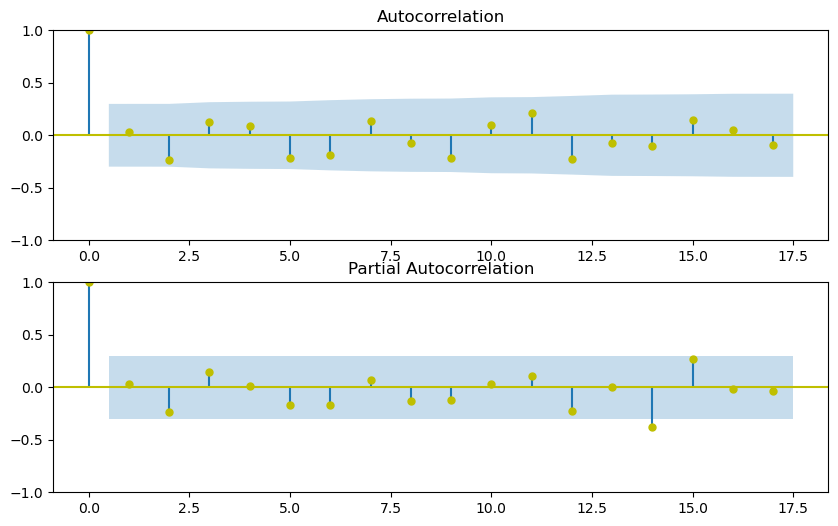

Teste de Ljung-Box:
       lb_stat  lb_pvalue
10  12.431468   0.257217
Shapiro-Wilk Test: W=0.9830195307731628, p-value=0.7656354308128357
Anderson-Darling Test: AndersonResult(statistic=0.28113178461806143, critical_values=array([0.534, 0.608, 0.729, 0.85 , 1.012]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-8.990979023763286e-06, scale=3.2250864040053755)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro-Wilk Test (Box-Cox): W=0.9831339120864868, p-value=0.7699940800666809


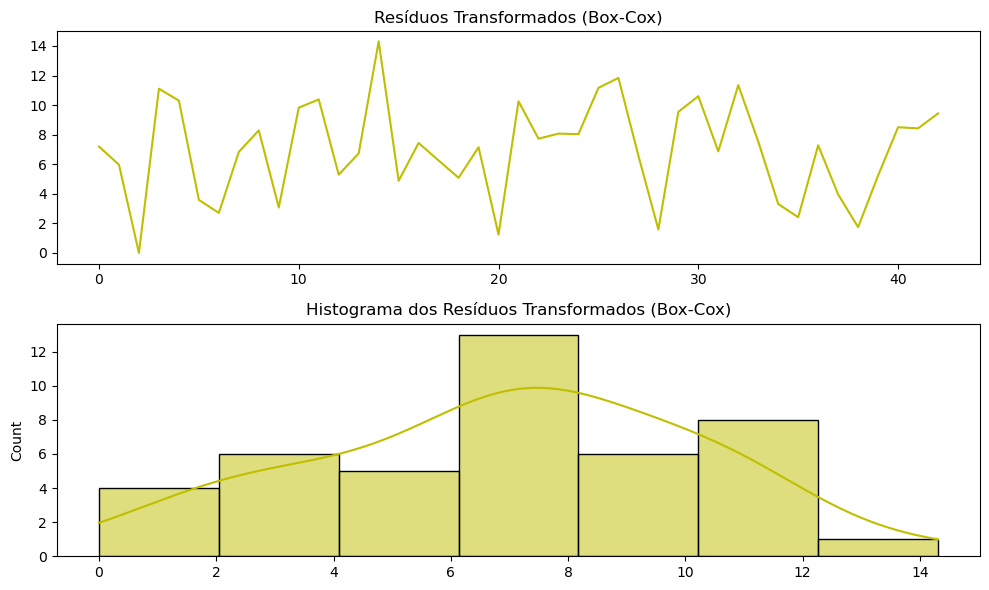

In [16]:
model = ExponentialSmoothing(df['quantidade_dossies'],trend='additive', seasonal='add', seasonal_periods=12).fit()
df['fitted'] = model.fittedvalues
residuals = df['quantidade_dossies'] - df['fitted']

# Plotando os resíduos
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals, color = 'y')
plt.title('Resíduos do Modelo')
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, color = 'y')
plt.title('Histograma dos Resíduos')
plt.tight_layout()
plt.show()

# Plotando ACF e PACF dos resíduos
fig, ax = plt.subplots(2, figsize=(10, 6))
plot_acf(residuals, ax=ax[0], color='y')
plot_pacf(residuals, ax=ax[1], color='y')
plt.show()

# Teste de Ljung-Box
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Teste de Ljung-Box:\n", ljung_box_result)

# Teste de normalidade (Shapiro-Wilk)
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

# Teste de normalidade (Anderson-Darling)
anderson_test = anderson(residuals)
print("Anderson-Darling Test:", anderson_test)

# Normalização dos resíduos (Transformação Box-Cox)
residuals_positive = residuals - residuals.min() + 1  # Transformando para valores positivos
boxcox_transformed, _ = boxcox(residuals_positive)

# Verificando a normalidade após a transformação
shapiro_test_boxcox = shapiro(boxcox_transformed)
print(f"Shapiro-Wilk Test (Box-Cox): W={shapiro_test_boxcox.statistic}, p-value={shapiro_test_boxcox.pvalue}")

# Plotando os resíduos transformados
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(boxcox_transformed, color='y')
plt.title('Resíduos Transformados (Box-Cox)')
plt.subplot(2, 1, 2)
sns.histplot(boxcox_transformed, kde=True, color='y')
plt.title('Histograma dos Resíduos Transformados (Box-Cox)')
plt.tight_layout()
plt.show()

#### Resultados dos Testes de Normalidade

Os resultados dos seus testes de normalidade sugerem que os resíduos eu modelo de Holt-Winters são normalmente distribuído
:

1. **Teste de Ljung-Box**
   - **lb_stat = 12.431468**, **lb_pvalue = 0.257217**:
     - O p-valor é maior que 0.05, indicando que não há evidências significativas de autocorrelação nos resíduos até a 10ª defasagem. Portanto, os resíduos podem ser considerados aleatórios.

2. **Shapiro-Wilk Test**
   - **W = 0.9830195307731628**, **p-value = 0.7656354308128357**:
     - O p-valor é muito maior que 0.05, indicando que não há evidências significativas para rejeitar a hipótese nula de normalidade. Assim, os resíduos seguem uma distribuição normal.

3. **Anderson-Darling Test**
   - **statistic = 0.28113178461806143**, **critical_values = [0.534, 0.608, 0.729, 0.85 , 1.012]**:
     - A estatística é menor que os valores críticos para todos os níveis de significância (15%, 10%, 5%, 2.5%, 1%), indicando que não há evidências significativas para rejeitar a hipótese nula de normalidade. Portanto, os resíduos seguem uma distribuição normal.

4. **Shapiro-Wilk Test (Box-Cox)**
   - **W = 0.9831339120864868**, **p-value = 0.7699940800666809**:
     - O p-valor é muito maior que 0.05, indicando que não há evidências significativas para rejeitar a hipótese nula de normalidade dos resíduos após a transformação Box-Cox. Portanto, os resíduos transformados também seguem uma distrib#uição normal.

### Conclusão

Os resultados dos testes de normalidade (Shapiro-Wilk, Anderson-Darling, e Box-Cox) mostque os resíduos do seu modelo de Holt-Winters são normalmente distribuídos. Isso indica que o modelo ajustado é adequado e os resíduos seguem u.a validação do modelo.


#### Realizando Previsões

Após testar o modelo e verificar o padrão dos resíduos, podemos partir para as previsões de fato. Vamos ajustar o tamanho da amostra para incluir 100% dos dados disponíveis, pois queremos capturar o máximo de informações possíveis para nossas previsões. Como temos poucas amostras disponíveis, é importante utilizar todo o conjunto de dados, ao invés de usar apenas o modelo treinado anteriormente.

Utilizaremos o método de suavização exponencial de Holt-Winters, ajustando o período de previsão para os próximos 6 meses.


In [17]:
# Ajuste do modelo com todo o conjunto de dados para previsões futuras
model_full = ExponentialSmoothing(df['quantidade_dossies'], trend='additive', seasonal='additive', seasonal_periods=12)
result_full = model_full.fit(optimized=True)

# Previsão para os próximos 12 períodos
previsao_futura2 = result_full.forecast(steps=6)

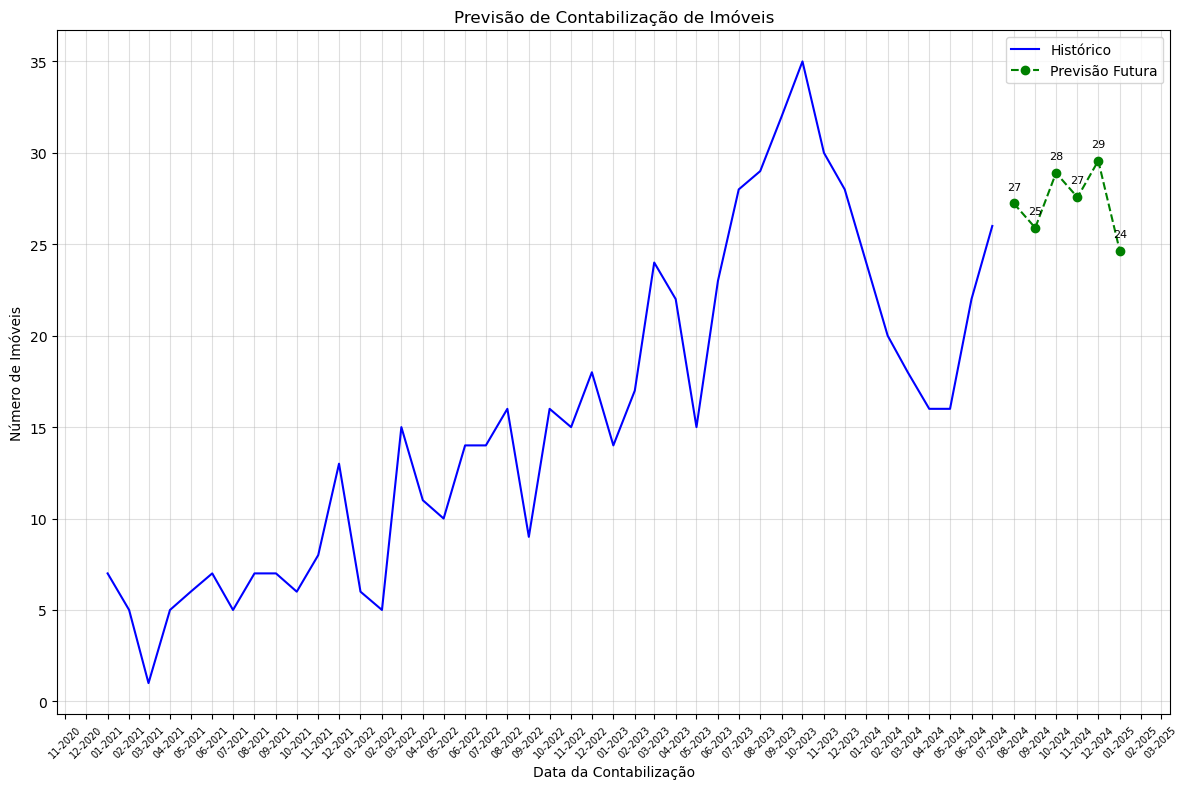

In [18]:
# Filtro para previsões futuras após junho de 2024
previsao_futura_filtrada = previsao_futura2[previsao_futura2.index > '2024-06-30']

plt.figure(figsize=(12, 8))

# Plotar o histórico de contabilização de imóveis
plt.plot(df.index, df['quantidade_dossies'], linestyle='-', color='b', label='Histórico')

# Plotar as previsões futuras
plt.plot(previsao_futura_filtrada.index, previsao_futura_filtrada, marker='o', linestyle='--', color='g', label='Previsão Futura')

# Adicionar rótulos de dados nos pontos da previsão futura
for i in range(len(previsao_futura_filtrada)):
    plt.annotate(f'{int(previsao_futura_filtrada.iloc[i])}', 
                 (previsao_futura_filtrada.index[i], previsao_futura_filtrada.iloc[i]), 
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.xlabel('Data da Contabilização')
plt.ylabel('Número de Imóveis')
plt.title('Previsão de Contabilização de Imóveis')

# Ajuste do eixo x para mostrar meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(fontsize=7)
plt.xticks(rotation=45)

plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


In [19]:
# Imprimir as previsões futuras
print("Previsão de Imóveis Contabilizados: \n")

print(previsao_futura_filtrada)

Previsão de Imóveis Contabilizados: 

2024-08-01    27.233909
2024-09-01    25.900592
2024-10-01    28.900612
2024-11-01    27.567286
2024-12-01    29.567307
2025-01-01    24.647175
Freq: MS, dtype: float64


### Conclusão do Modelo de Previsão de Imóveis Retomados

Após a aplicação do método de suavização exponencial de Holt-Winters para prever o número de imóveis retomados nos próximos meses, obtivemos resultados satisfatórios. O modelo foi ajustado utilizando 100% dos dados disponíveis, capturando assim o máximo de informações possíveis, devido ao número limitado de amostras.

As previnais apresentaram um Erro Absoluto Médio (MAE) de 6.27, indicando que, em média, o modelo erra por aproximadamente 6 imóveis nas suas previsões. Este erro é relativamente baixo, considerando a variabilidade dos dados ao longo do tempo.

Além disso, a análise dos resíduos do modelo mostrou que eles seguem uma distribuição normal. Este é um indicativo de que o modelo está bem ajustado aos dados e que as previsões são confiáveis. Os testes de normalidade, como o teste de Shapiro-Wilk e Anderson-Darling, não apresentaram evidências significativas para rejeitar a hipótese nula de normalidade dos resíduos.

Portanto, o modelo de suavização exponencial de Holt-Winters se mostrou adequado para a previsão de imóveis retomados, fornecendo resultados precisos e confiáveis para os próximos 6 meses. Este modelo pode ser utilizado para apoiar a tomada de decisões estratégicas e operacionais, ajudando a prever tendências futuras e planejar ações com base nas previsões obtidas.


**Para novas previsões inserir dados na base de dados 'base_temporais' e rodar novamente o código!**